# Homework 3

This homework will explore linear regression and resampling techniques by analysing data from a database of glaciers. The database is *Glatilda* for [*Glacier Ice Thickness Database*](!https://www.gtn-g.ch/data_catalogue_glathida/).

1. Data prep (5 points)
2. Mapping (10 points)
3. Correlations between parameters (5 points)
4. Linear regression and resampling techniques (10 points)

## 1. Data Prep (5 points total)

### a) Download data (1 point) 
The database is saved on a GitLab repository that you may clone: https://gitlab.com/wgms/glathida.git



In [96]:
# answer
!git clone https://gitlab.com/wgms/glathida.git

fatal: destination path 'glathida' already exists and is not an empty directory.


### b) Import Python modules (1 point) 
Import pandas, geopandas, plotting, raster files,  numpy, netcdf

In [97]:
# solution
import requests, zipfile , os, io
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd
# import pycrs
import rasterio
import h5py
import rasterio
import netCDF4 as nc
!pip install wget
import wget
from folium.plugins import MarkerCluster
from rasterio.mask import mask
from rasterio.plot import show


### c) Read data (2 points)
Read the glacier data from the file ``glathida/data/glacier.csv`` into a pandas data frame, and decribe briefly the dataframe content and its first few lines.

In [98]:
# solution
t_path = "glathida/data/glacier.csv"

cat = pd.read_csv(t_path)
print(cat.columns)
cat.head()

Index(['id', 'survey_id', 'name', 'external_db', 'external_id', 'lat', 'lon',
       'date', 'max_date', 'area', 'mean_slope', 'mean_thickness',
       'mean_thickness_uncertainty', 'max_thickness',
       'max_thickness_uncertainty', 'number_points', 'number_profiles',
       'length_profiles', 'interpolation_method', 'flag', 'remarks'],
      dtype='object')


,id,survey_id,name,external_db,external_id,lat,lon,date,max_date,area,...,mean_thickness,mean_thickness_uncertainty,max_thickness,max_thickness_uncertainty,number_points,number_profiles,length_profiles,interpolation_method,flag,remarks
0,1,1,Isfallsglaciären,WGI,SE4B000E0006,67.91500,18.56800,1979-03-01,1979-03-31,1.3,...,72.0,NaN,220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,Rabots glaciär,WGI,SE4B000E1016,67.91000,18.49600,1979-03-01,1979-03-31,4.1,...,84.0,NaN,175.0,NaN,NaN,10.0,NaN,NaN,NaN,NaN
2,3,1,Storglaciären,WGI,SE4B000E0005,67.90000,18.57000,1979-03-01,1979-03-31,3.1,...,99.0,NaN,250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2,South Cascade Glacier,WGI,US2M00264006,48.35698,-121.05735,1975-01-01,1975-12-31,2.0,...,99.0,NaN,195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,3,Athabasca Glacier,FOG,7,52.17540,-117.28400,NaN,NaN,3.8,...,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Explore the data with visualization**
Before making any inference of models with the data, we will start by exploring basic correlations among parameters by plotting. In particular, we will focus on ``mean_thickness``, ``area``, ``mean_slope`` parameters.

### d) Remove bad data (1 point)

The database may contain Nans and other "bad" values (welcome to the data world!). First we will clean the data by removing nans. We are mostly interested in the thickness, area, and slope



In [105]:
#answer below 
cat = cat.dropna(subset=['mean_thickness','area','mean_slope'])
cat

,id,survey_id,name,external_db,external_id,lat,lon,date,max_date,area,...,mean_thickness,mean_thickness_uncertainty,max_thickness,max_thickness_uncertainty,number_points,number_profiles,length_profiles,interpolation_method,flag,remarks
32,33,9,Easton Glacier,FOG,1367,48.750000,-121.830000,1992-01-01,1992-12-31,2.900,...,58.0,NaN,107.0,NaN,64.0,NaN,NaN,NaN,NaN,NaN
33,34,10,Lemon Creek Glacier,FOG,3334,58.380000,-134.360000,1956-06-21,1956-09-22,11.700,...,66.0,NaN,200.0,NaN,182.0,NaN,NaN,NaN,NaN,NaN
44,45,14,Fedchenko Glacier,NaN,NaN,38.767000,72.283000,NaN,NaN,824.000,...,175.0,NaN,900.0,NaN,NaN,NaN,NaN,NaN,NaN,LAT/LON: Wikipedia
47,48,16,Kavrayskogo,WGI,SU5X13207002,45.236450,80.781660,1962-01-01,1962-12-31,3.200,...,49.0,NaN,116.0,NaN,NaN,NaN,NaN,NaN,NaN,LAT/LON: FoG 2009
48,49,16,Krasovskogo,WGI,SU5X13207003,45.235130,80.808350,1962-01-01,1962-12-31,3.400,...,49.0,NaN,139.0,NaN,NaN,NaN,NaN,NaN,NaN,LAT/LON: Katalog Lednikow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,2107,183,Ålfotbreen (south),NVE,2096,61.730000,5.660000,2016-04-12,NaN,3.280,...,68.0,NaN,163.0,NaN,426.0,NaN,NaN,other,NaN,INTERPOLATION_METHOD: Inverse Distance Weighti...
619,2111,187,Blekumbreen,GLIMS,G016068E78246N,78.245480,16.064380,2013-04-27,NaN,2.100,...,32.0,NaN,106.0,NaN,4484.0,26.0,22.5,anudem,partial,MEAN_THICKNESS: Based on the interpolated enti...
627,2119,193,Tuyuksu (central),GLIMS,G077080E43049N,43.043653,77.080587,2013-08-28,NaN,2.610,...,47.0,2.0,103.0,2.0,8568.0,36.0,25.0,anudem,partial,MEAN_THICKNESS: Based on the interpolated enti...
631,2123,195,Aldegondabreen,RGI,RGI50-07.01079,77.971400,14.069100,1999-05-06,1999-05-08,6.737,...,65.0,7.0,191.0,25.0,2018.0,24.0,40.0,kriging,NaN,MEAN_SLOPE: Altitude range/glacier length | ME...


## 2. Mapping glaciers (10 points)

Make a global map of the glaciers. Use either of the tools we learned in class:
* Geopandas, DEMs from NetCDFfiles (see chapter 2.4)
* Pandas and Plotly (see chapter 2.2). You may need to transform some of the series into log-spaced values for better visualization.

### Option 1: Tif and matplotlib

You can use the ``elevation`` data from the DEM seen in class. Download the DEM file (https://www.dropbox.com/s/j5lxhd8uxrtsxko/HYP_50M_SR.tif?dl=1)

In [106]:
# solution
# Dowload the data using wget.
fname = 'HYP_50M_SR'
wget.download('https://www.dropbox.com/s/j5lxhd8uxrtsxko/HYP_50M_SR.tif?dl=1') # note the last character as a string to request the file itself


'HYP_50M_SR (3).tif'


___Tips___: when plotting a image in ``matplotlib`` you need to add information about the physical dimensions of the image. You can calculate the ``bounds``.

In [107]:
elevation = rasterio.open(fname+".tif")
bounds = (elevation.bounds.left, elevation.bounds.right, \
          elevation.bounds.bottom, elevation.bounds.top)



We will use ``matplotlib.pyplot`` to show the raster image in the background (tips: use ``imshow()``. The raster image in matplotlib can only import one frame and not three (R, G, B) frames. We will first stack the three images together. 

In [108]:
red = elevation.read(1)
green = elevation.read(2)
blue = elevation.read(3)
pix = np.dstack((red, green, blue))

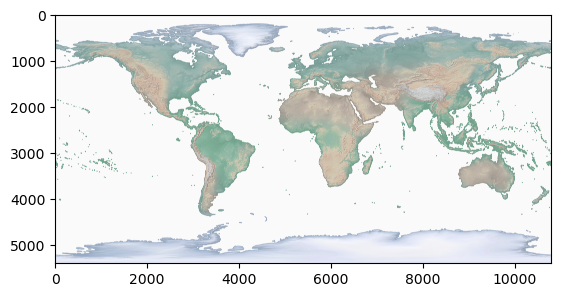

In [109]:
# solution
plt.imshow(pix)

## Option 2: Plotly

You may use plotly. For improved visibility, transform some of the data into log-spaced. You may add these transformed Series into the Pandas, and use them as input to plotly.

In [110]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'vscode' # writes as standalone html, 
# pio.renderers.default = 'iframe' # writes files as standalone html, 
# pio.renderers.default = 'png' # writes files as standalone html, 
# try notebook, jupyterlab, png, vscode, iframe

In [111]:
# solution


## 3. Correlations between data parameters ( 5 points total)

Make plots to vizualise the correlation, or lack of, between all three data. Make at least three plots.

### a) Basic correlations using Matplotlib (2 points)

Make 3 plots using matplotlib to visualize slope, mean_thickness, and area. Use logscale to see the correlatons.

__Tips__: 
* Use the function ``scatter`` to plot the values of mean thickness, mean slope, area, and latitude. 
* use one of the dataframe columns as a color using the argument ``c``. You can also vary the ``colormap`` using the argument ``cmap``. Help on colormaps can be found here: https://matplotlib.org/stable/tutorials/colors/colormaps.html. Be mindful of Color-Vision Deficient readers and read *Crameri, F., Shephard, G.E. and Heron, P.J., 2020. The misuse of colour in science communication. Nature communications, 11(1), pp.1-10. https://doi.org/10.1038/s41467-020-19160-7* (find it on the class Gdrive). You can add a third "data" by choosing a marker color that scales with an other parameter. For instance, try coloring your marker with the ``LAT`` parameter to look at systematic latitudinal trends from the equator to the poles.
* Do not forget to adjust fontsize, figure size (at least 10,8), grid, labels with  of the features (example: km). ou may also explore the *logarithmic* correlations by mapping the axis from linear to logarithmic scale ``plt.xscale('log')``.

Text(0.5, 0, 'Mean Slope')

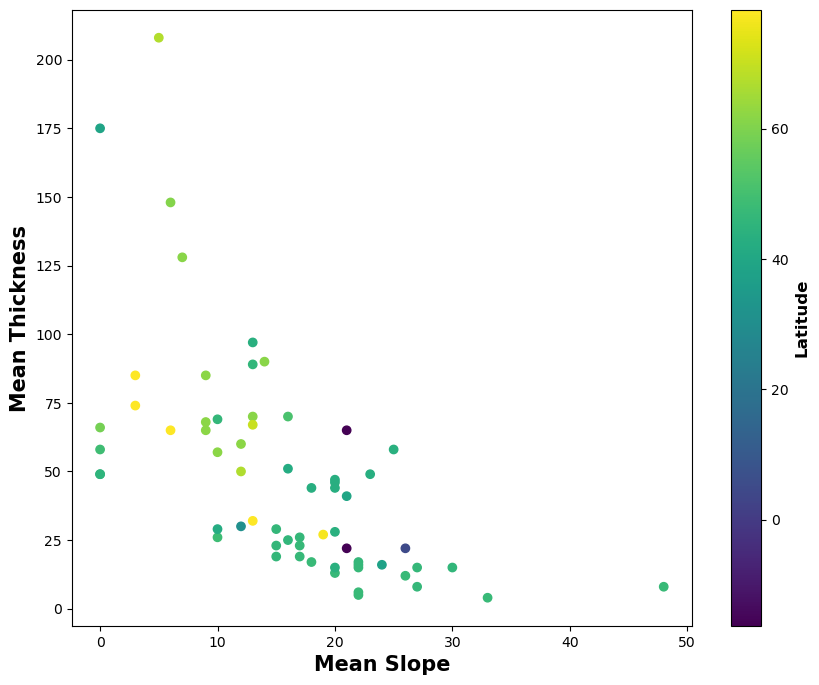

In [112]:
# Figure 1: Mean slope vs mean thickness
# solution

plt.figure(figsize = [10,8])
plt.scatter(cat['mean_slope'].values, cat['mean_thickness'].values, c = cat['lat'])
ax = plt.colorbar()
ax.set_label('Latitude', fontsize=12, fontweight='bold')
plt.ylabel('Mean Thickness', fontsize=15, fontweight='bold')
plt.xlabel('Mean Slope', fontsize=15, fontweight='bold')

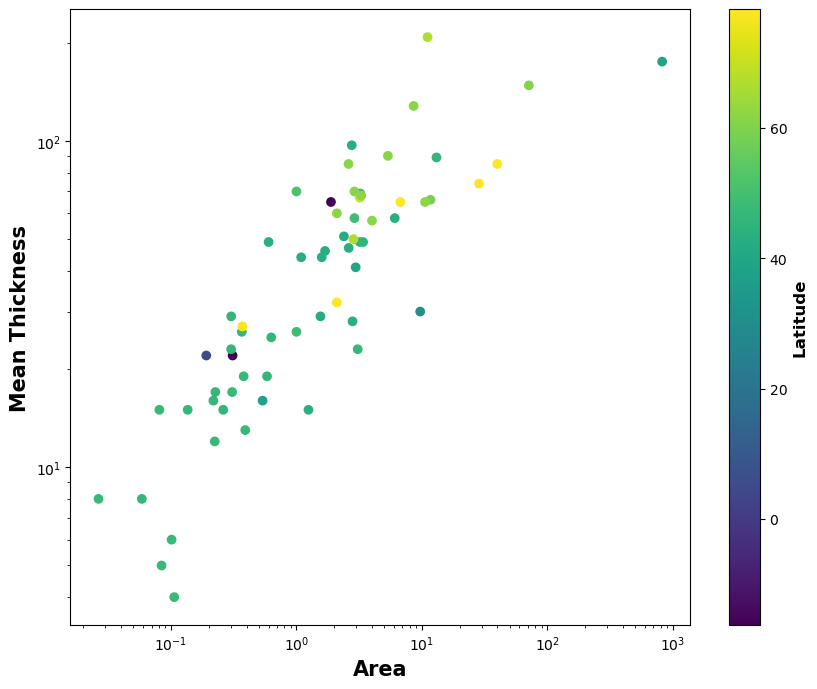

In [126]:
# Figure 2: area vs mean thickness
# solution

plt.figure(figsize = [10,8])
plt.scatter(cat['area'].values, cat['mean_thickness'].values, c = cat['lat'])
ax = plt.colorbar()
ax.set_label('Latitude', fontsize=12, fontweight='bold')
plt.ylabel('Mean Thickness', fontsize=15, fontweight='bold')
plt.xlabel('Area', fontsize=15, fontweight='bold')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(0,20)

### b) 3D Scatter plot using Plotly (1 point)

Use the plotly ``scatter_3d`` plot. Make sure to change the pandas series for log scales.

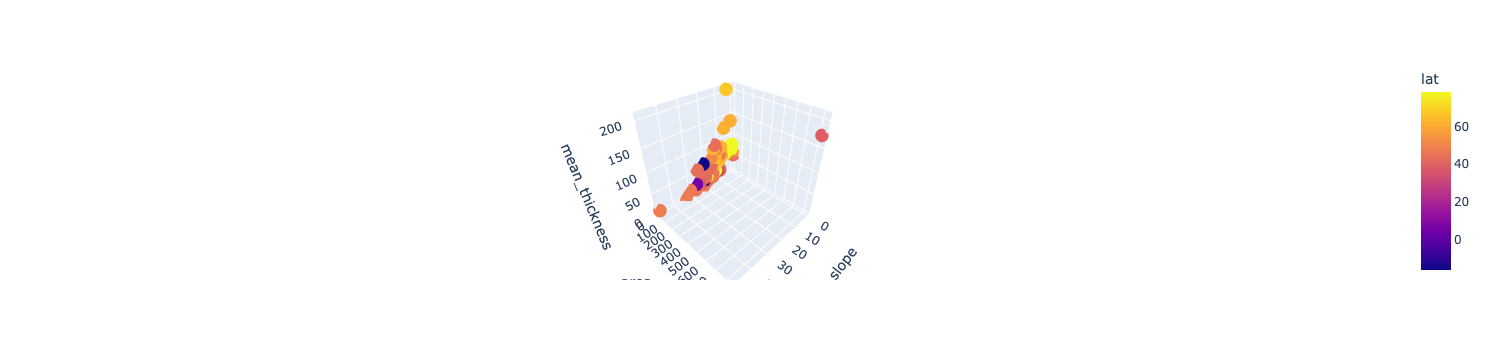

In [114]:
# solution
import plotly.express as px
fig = px.scatter_3d(cat, x='mean_slope', y='area', z='mean_thickness',
              color='lat')
fig.show()

### c) Pandas Correlation function (1 point)

You may use Pandas functionalities to explore correlation between data. Use the function ``corr`` on the dataframe and the matplotlib function ``matshow`` to plot a heatmap of the correlations

/tmp/ipykernel_102/1291452231.py:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



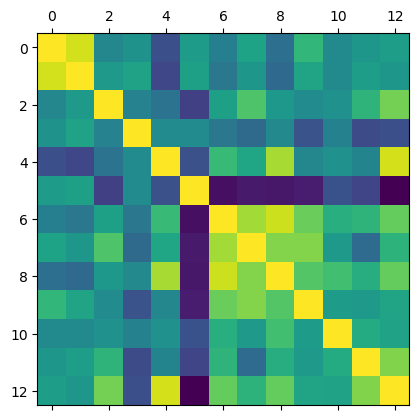

In [115]:
#solution


plt.matshow(cat.corr())
plt.show()

### f) Seaborn Plotting (1 point)

Seaborn is a great python package for basic data anlytics. See documentation [here](!https://seaborn.pydata.org/). You can visualize the data by plotting data features against each other and explore visually data correlations.

In [116]:
#solution

/tmp/ipykernel_102/1106151019.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<AxesSubplot: >

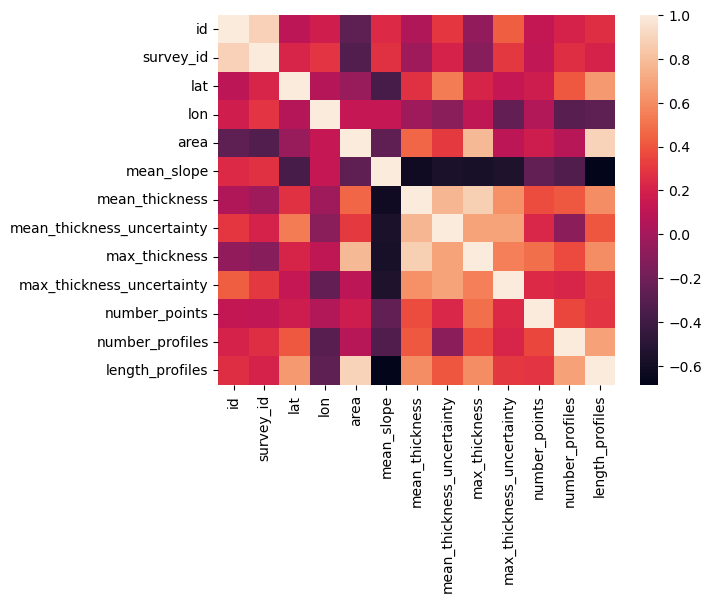

In [117]:
# solution
import seaborn as sns
sns.heatmap(cat.corr())

Discuss the basic correlations among the data. Do these correction make sense when you think about the shapes of glaciers?

Yes! I noticed that mean_slope is least correlated with other parameters. 


## 4. Linear Regression (10 points total counted in the next section)
You found from basic data visualization that the three parameters ``mean_slope``, ``mean_thickness``, and ``area`` are correlated. It does make physical sense because a *steep* glaciers is likely to be in the high mountains regions, hanging on the mountain walls, and thus be constrained, and conversely, a flat glacier is either at its valley, ocean terminus or on ice sheets.

### a) Simple linear regression (2 points)
We will now perform a regression between the parameters (or their log!). Linear regressions are models that can be imported from scikit-learn. Log/exp functions in numpy as ``np.log()`` and ``np.exp()``.
Remember that a linear regression is finding $a$ and $b$ knowing both $x$ and the data $y$ in $y = Ax +b$. We want to predict ice thickness from a crude estimate of the glacier area.

__Tips__: 
a. make sure that the dimensions are correct and that there is no NaNs and zeros.
b. Make sure to inport the scikit learn linear regression function and the error metrics.

In [118]:
# solution
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


Make a plot of the data and the linear regression your performed

Coefficients: 
 [[0.37014767]]
Mean squared error: 0.24
Coefficient of determination: 0.72


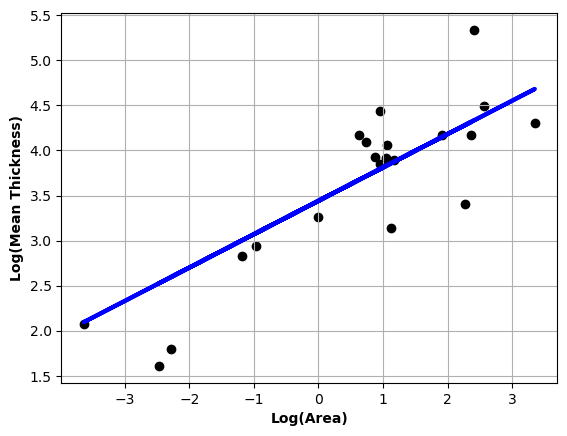

In [145]:
# solution

X = np.log(np.array(cat['area']).reshape(-1,1))
y = np.log(np.array(cat['mean_thickness']).reshape(-1,1))

 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)


# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X_test, y_test, color="black")
plt.plot(X_test, y_pred, color="blue", linewidth=3)

#plt.xticks(())
#plt.yticks(())
plt.grid()
plt.xlabel('Log(Area)', fontweight='bold')
plt.ylabel('Log(Mean Thickness)', fontweight='bold')
plt.show()


**Briefly comment on the quality of your fit and a linear regression (1 point)**

The fit looks pretty good, except that there are outliers on the extreme low and high values of mean area.

### b) Leave One Out Cross Validation linear regression (1 point)


Perform the LOCCV on the ``area`` and ``thickness`` values. Predict the ``thickness`` value knowing a ``area`` value. Use material seen in class. Make a plot of your fit.

In [141]:
from sklearn.model_selection import LeaveOneOut
# solution
loo = LeaveOneOut()
vel = np.zeros(len(X)) # initalize a vector to store the regression values
mse_train = np.zeros(len(X))
mse_val = np.zeros(len(X))
r2s = np.zeros(len(X))

for i, (train_index, test_index) in enumerate(loo.split(X)):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # now fit the data on the training set.
        regr = LinearRegression()
        # Fit on training data:
        regr.fit(X_train,y_train)
        # We will first predict the fit:
        Epred_train=regr.predict(X_train) 
        Epred_val=regr.predict(X_test) 

        # The coefficients
        vel[i]= regr.coef_[0][0]
        mse_train[i]= mean_squared_error(y_train, Epred_train)
        mse_val[i]= mean_squared_error(y_test, Epred_val)
        r2s[i]=r2_score(y_test, Epred_val)
        i+=1
    
# the data shows cleary a trend, so the predictions of the trends are close to each other:
print("mean of the slope estimates %f4.2 and the standard deviation %f4.2"%(np.mean(vel),np.std(vel)))
# the test error is the average of the mean-square-errors
print("CV = %4.2f"%(np.mean(mse_val)))


TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning:

R^2 score is not well

### c) Bootstrapping (1 point)

Perform the same analysis but using a bootstrapping technique. Output the mean and standard deviation of the slope. An illustration with a histogram  may help.

In [ ]:
from sklearn.utils import resample
# solution

k=100



mean of the velocity estimates 0.3984794.2 and the standard deviation 0.0386354.2


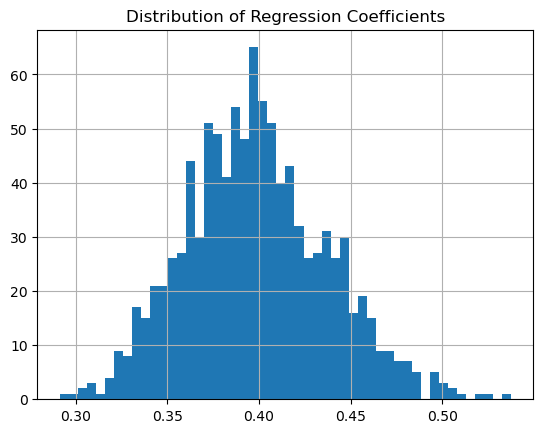

In [150]:
from sklearn.utils import resample


k=1000
b = np.zeros(k) # initalize a vector to store the regression values
mse = np.zeros(k)
r2s = np.zeros(k)
i=0
for iik in range(k):    
    ii = resample(np.arange(len(X)),replace=True,n_samples=len(X))# new indices
    X_b, y_b = X[ii], y[ii]
    # now fit the data on the training set.
    regr = LinearRegression()
    # Fit on training data:
    regr.fit(X_b,y_b)
    Epred_val=regr.predict(X) # test on the validation set.

    # The coefficients
    b[i]= regr.coef_[0][0]
    i+=1

# the data shows cleary a trend, so the predictions of the trends are close to each other:
print("mean of the velocity estimates %f4.2 and the standard deviation %f4.2"%(np.mean(b),np.std(b)))

plt.hist(b,50);plt.title('Distribution of Regression Coefficients');plt.grid(True)
plt.show()

### d) Predict the thickness of a glacier (2 points)

Let assume that you measure a glacier of area 10 km$^2$. Can you use your bootstrap regression framework to provide a distribution of possible values of the ice thickness ? Output the mean and standard deviation of the predicted ice thickness.

mean of the regression coefficients estimates 0.3972194.2 and the standard deviation 0.0406134.2


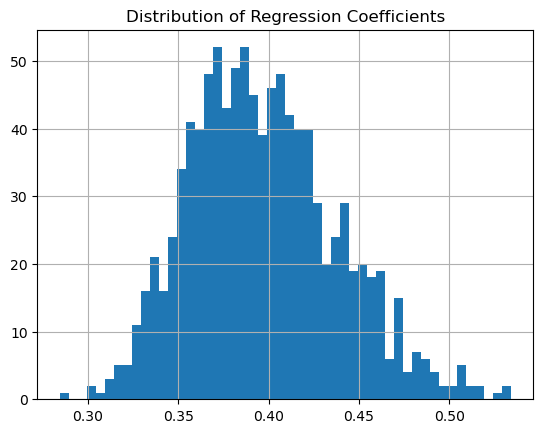

In [155]:
# solution

from sklearn.utils import resample


k=1000
b = np.zeros(k) # initalize a vector to store the regression values
mse = np.zeros(k)
r2s = np.zeros(k)
Epred_val = np.zeros(k)
i=0
for iik in range(k):    
    ii = resample(np.arange(len(X)),replace=True,n_samples=len(X))# new indices
    X_b, y_b = X[ii], y[ii]
    # now fit the data on the training set.
    regr = LinearRegression()
    # Fit on training data:
    regr.fit(X_b, y_b)
    Epred_val[iik] = regr.predict(np.array(np.log(10)).reshape(-1,1))# test on the validation set.
    
    # The coefficients
    b[i]= regr.coef_[0][0]
    i+=1

# the data shows cleary a trend, so the predictions of the trends are close to each other:
print("mean of the regression coefficients estimates %f4.2 and the standard deviation %f4.2"%(np.mean(b),np.std(b)))

plt.hist(b,50);plt.title('Distribution of Regression Coefficients');plt.grid(True)
plt.show()

In [158]:
import math 

print("mean of the glacier thickness estimated from model for an area of 10 km^(2) is  %f4.2 and its standard deviation is %f4.2"%(math.e**(np.mean(Epred_val)),math.e**(np.std(Epred_val))))

mean of the glacier thickness estimated from model for an area of 10 km^(2) is  76.1884124.2 and its standard deviation is 1.1073714.2
